In [1]:
# import os
import matplotlib.pyplot as plt
import os
import pandas as pd
from amftrack.util.sys import get_analysis_folders,get_time_plate_info_from_analysis,get_time_hypha_info_from_analysis,get_global_hypha_info_from_analysis 
import numpy as np
import imageio
import os
import cv2
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from amftrack.pipeline.final_analysis.density_wave import get_wave_fit, S, dS, wave, dwave
import matplotlib.patches as mpatches
from random import choice
import matplotlib as mpl
from amftrack.pipeline.final_analysis.density_wave import plot_single_plate,plot_single_plate_biovolume
from amftrack.pipeline.final_analysis.hypha_speed_analysis import *
from amftrack.util.plot import gridplot, make_stat
from helper import *
from load_dataframes import load_all
from plates import plates,timestep
%store -r path_figure
%matplotlib widget
%load_ext autoreload
%autoreload 2
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy
import statsmodels.api as sm
import hashlib
from matplotlib.patches import Ellipse
import logging
plt.style.use('presentation.mplstyle')
logging.getLogger().setLevel(logging.WARNING)




c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
df,final_data = load_all(plates)

C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:102: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['start'] = pd.to_datetime(df_sum['start'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:103: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df_sum['crossed']  = pd.to_datetime(df_sum['crossed'], errors='coerce')
C:\Users\coren\Documents\PhD\Code\pycode\P_depletion_paper\final_figures\load_dataframes.py:104: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsi

In [3]:
def calculate_derivative(df, column, new_column, window=1):
    # Ensure the DataFrame is sorted by 'unique_id' and 'time_since_begin_h'
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    
    # Calculate the time difference and value difference over the desired window
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_h'].transform(lambda x: x.diff(window)).fillna(0)
    df['value_diff'] = df.groupby('unique_id')[column].transform(lambda x: x.diff(window)).fillna(0)

    # Calculate the derivative (value difference divided by time difference)
    # Be cautious about dividing by zero. If 'time_diff' is 0, set derivative to NaN or handle accordingly.
    df[new_column] = df.apply(lambda x: x['value_diff'] / x['time_diff'] if x['time_diff'] != 0 else None, axis=1)

    # Drop the helper columns
    df.drop(['time_diff', 'value_diff'], axis=1, inplace=True)
def calculate_integral(df, column, new_column):
    # Calculate the time difference within each group
    df.sort_values(by=['unique_id', 'time_since_begin_h'], inplace=True)
    df['time_since_begin_hour'] = df['time_since_begin_h']
    df['time_diff'] = df.groupby('unique_id')['time_since_begin_hour'].transform(lambda x: x.diff())

    # Calculate the average length density within each group
    df['avg_length_density'] = df.groupby('unique_id')[column].transform(lambda x: x.rolling(window=2).mean())

    # Calculate the "area" (using Trapezoidal rule) for each pair of rows within each group
    df['area'] = df['time_diff'] * df['avg_length_density']

    # Perform the integration (cumulative sum of "area") within each group
    df[new_column] = df.groupby('unique_id')['area'].transform(lambda x: x.cumsum())

    # Drop the helper columns if needed
    df.drop(['time_diff', 'avg_length_density', 'area'], axis=1, inplace=True)
Vmax = 3e-9*25 #ugP/um2/hour
density = 1e-6 #ug/um3
dry_wet_ratio = 0.3
carbon_ratio = 0.5
carbon_ratio_spore = 0.9
dry_wet_ratio_spore = 0.9
density_spore = 0.9e-6
respiration_ratio = 0.5
baseline = final_data[final_data['time_since_begin_h'] == 0]
# Step 2: Create a series with spore_volume at time_since_begin_h = 0 for each unique_id
baseline_volume = baseline.groupby('unique_id')['spore_volume'].first()
final_data['adjusted_spore_volume'] = final_data.groupby('unique_id')['spore_volume'].transform(lambda x: x - baseline_volume[x.name])
final_data['totC_hypha'] = final_data['tot_biovolume_study']*density*dry_wet_ratio*carbon_ratio
final_data['tot_volume'] = final_data['adjusted_spore_volume']+final_data['tot_biovolume_study']
final_data['totC_spore'] = final_data['adjusted_spore_volume']*density_spore*dry_wet_ratio_spore*carbon_ratio_spore
final_data['totC_tot'] = final_data['totC_hypha'] + final_data['totC_spore']
calculate_integral(final_data,f'tot_surface_area_study',f'integrated_SA')
calculate_derivative(final_data,f'tot_biovolume_study',f'derivative_biovolume', window=5)
calculate_derivative(final_data,f'derivative_biovolume',f'acceleration_biovolume', window=5)


final_data['P_rate'] =final_data['tot_surface_area_study']*Vmax
final_data['C_rate'] = final_data['derivative_biovolume']*density*dry_wet_ratio*carbon_ratio/respiration_ratio

final_data = final_data.reset_index(drop=True)

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
n_colors = len(final_data['strain'].unique())

strain_to_color={"C2": (0.17058823529411765, 0.4946558433997788, 0.9667184042691874),
 "A5": (0.16666666666666663, 0.8660254037844386, 0.8660254037844387),
 "Agg": (0.503921568627451, 0.9999810273487268, 0.7049255469061472),
 "Clarum": (0.8333333333333333, 0.8660254037844387, 0.5000000000000001),
 "C3": (1.0, 0.4946558433997788, 0.2558427775944356)}

In [5]:
final_data['unique_id'].unique()

array([3.20220426e+08, 1.22022050e+09, 1.62022042e+09, 2.82023023e+09,
       5.22022071e+09, 8.42022062e+09, 9.12022071e+09, 2.02202303e+10,
       2.19202303e+10, 2.29202303e+10, 2.41202304e+10, 2.48202303e+10,
       2.49202303e+10, 2.52202303e+10, 3.01202307e+10, 3.04202307e+10,
       3.23202308e+10, 3.58202310e+10, 3.66202309e+10, 3.72202309e+10,
       3.73202309e+10, 3.77202309e+10, 4.36202307e+10, 4.43202307e+10,
       4.47202308e+10, 4.62202210e+10, 4.68202308e+10, 4.71202308e+10,
       4.72202210e+10, 4.74202308e+10, 4.80202212e+10, 4.82202309e+10,
       4.83202310e+10, 4.86202310e+10, 4.92202309e+10, 5.06202211e+10,
       5.10202212e+10, 5.13202212e+10, 5.14202212e+10, 5.21202301e+10,
       5.27202301e+10, 5.30202301e+10, 5.31202212e+10, 5.32202201e+10,
       5.37202301e+10, 5.52202301e+10, 5.59202301e+10, 7.64202212e+10,
       7.71202304e+10, 7.72202303e+10, 7.77202303e+10, 7.95202304e+10,
       7.96202304e+10, 8.68202305e+10, 8.70202304e+10, 8.86202305e+10,
      

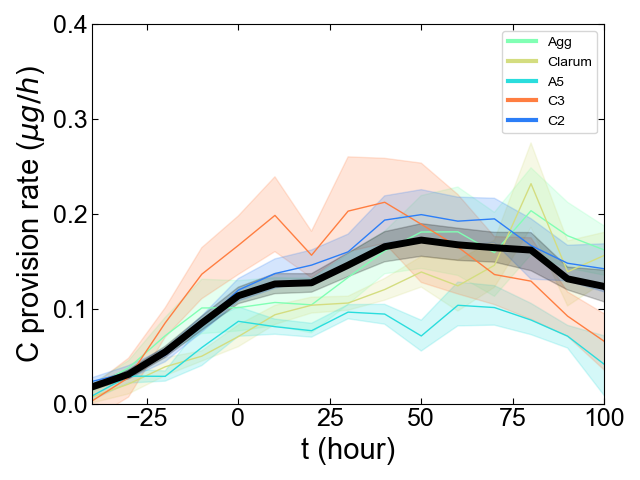

In [6]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['real_root']=="Carrot Toby"]

sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], hue='strain',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,0.4)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-40,100)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


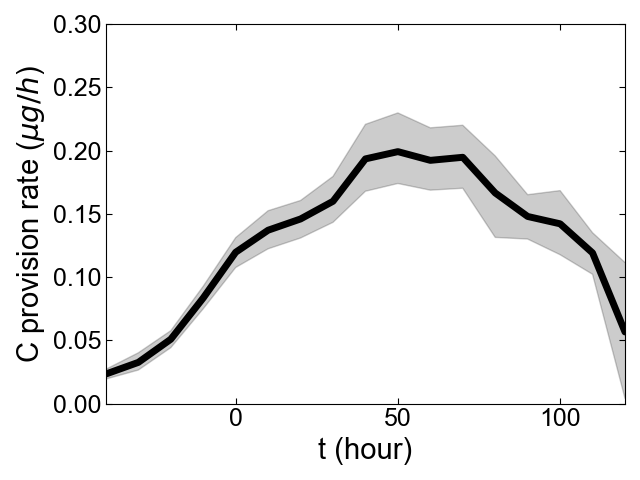

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sample data
# I don't have access to your 'final_data', so I'm just using this structure for demonstration purposes.

# fig,ax setup
fig, ax = plt.subplots()

# Filter your data
tmax = 150
select = final_data[final_data['time_since_begin_h_shifted'] <= tmax]
select = final_data[final_data['real_root'] == "Carrot Toby"]
select = select[select['strain'] == "C2"]

# Plot each individual trajectory
# for unique_id in select['unique_id'].unique():
#     individual_data = select[select['unique_id'] == unique_id]
#     ax.plot(individual_data['time_since_begin_h_shifted'], individual_data['C_rate'], alpha=0.5,color="grey") # You can adjust alpha for visibility

# Plot the mean trajectory
sns.lineplot(data=select, x='time_hour_binned', y='C_rate', ax=ax, color='black', estimator='mean', lw=5, ls="-")

# Adjusting the plot
# ax.legend().remove()  # If you don't want to show the legend
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0, 0.3)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlim(-40, 120)

plt.tight_layout()

# Save the figure
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')
plt.show()


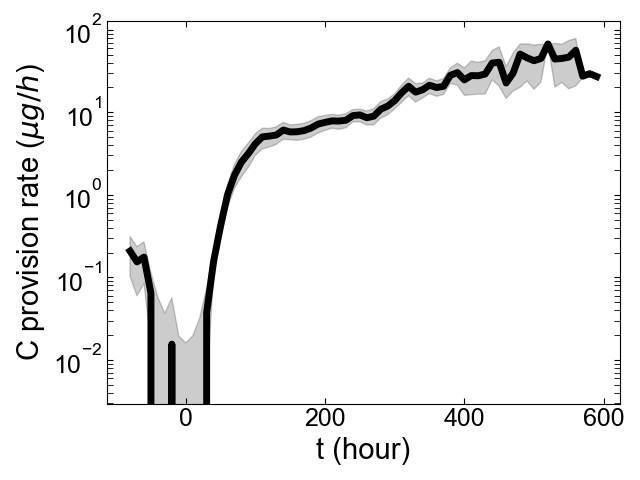

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Sample data
# I don't have access to your 'final_data', so I'm just using this structure for demonstration purposes.

# fig,ax setup
fig, ax = plt.subplots()

# Filter your data
tmax = 150
select = final_data[final_data['time_since_begin_h_shifted'] <= tmax]
select = final_data[final_data['real_root'] == "Carrot Toby"]
select = select[select['strain'] == "C2"]

# Plot each individual trajectory
# for unique_id in select['unique_id'].unique():
#     individual_data = select[select['unique_id'] == unique_id]
#     ax.plot(individual_data['time_since_begin_h_shifted'], individual_data['C_rate'], alpha=0.5,color="grey") # You can adjust alpha for visibility

# Plot the mean trajectory
sns.lineplot(data=select, x='time_hour_binned', y='totC_spore', ax=ax, color='black', estimator='mean', lw=5, ls="-")

# Adjusting the plot
# ax.legend().remove()  # If you don't want to show the legend
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0, 0.3)
ax.set_ylabel('C provision rate ($\mu g/h$)')
# ax.set_xlim(-40, 120)
ax.set_yscale("log")
plt.tight_layout()

# Save the figure
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')
plt.show()


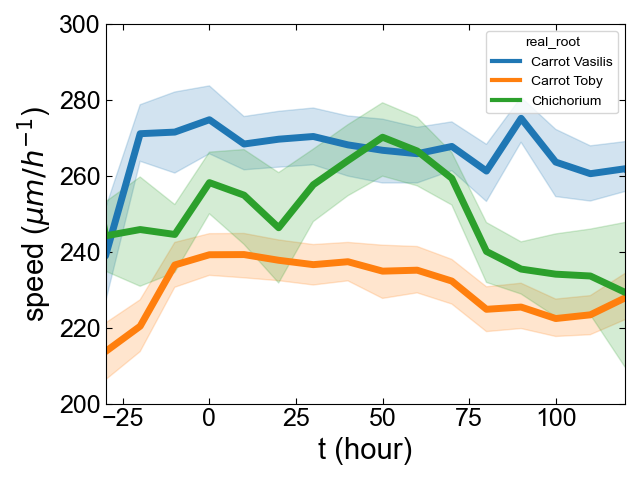

In [9]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
# select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain'] == "C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['hull_speed'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('speed ($\mu m/h^{-1}$)')
ax.set_ylim(200,300)
ax.set_xlim(-30, 120)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


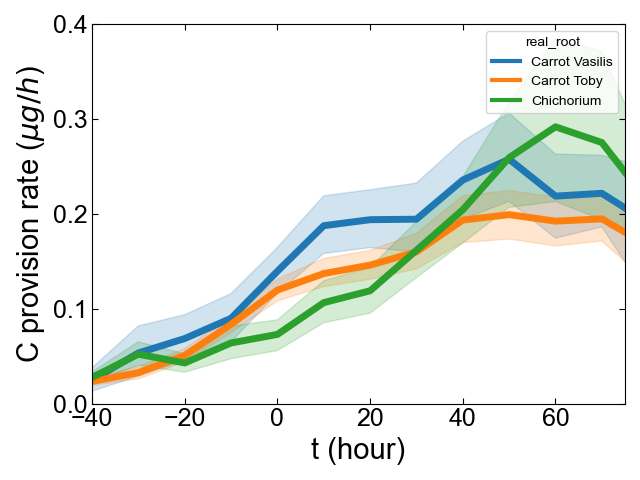

In [10]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
# sns.lineplot(data=select, x='time_hour_binned', y=select['C_rate'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
ax.set_ylim(0,0.4)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [11]:
def plot_scatter_with_mean_and_ci(df, x_col, y_col, ax, label=None):
    n_colors = len(df['strain'].unique())
    palette = sns.color_palette("rainbow", n_colors)
    strain_to_color = dict(zip(df['strain'].unique(), palette))
    sns.scatterplot(data=df, x=x_col, y=y_col, hue='strain', palette=strain_to_color, ax=ax,s = 15)

    for strain, color in strain_to_color.items():
        sub_df = df[df['strain'] == strain]
        x_mean = sub_df[x_col].mean()
        y_mean = sub_df[y_col].mean()
        x_ci = sub_df[x_col].std()
        y_ci = sub_df[y_col].std()
        ax.errorbar(x=x_mean, y=y_mean, xerr=x_ci, yerr=y_ci, color=color, fmt='o',markersize=20)
    # sns.regplot(x=df.groupby('strain')[x_col].mean(), y=df.groupby('strain')[y_col].mean(), scatter=False, color="black", ax=ax)

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    if label:
        ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top')
    

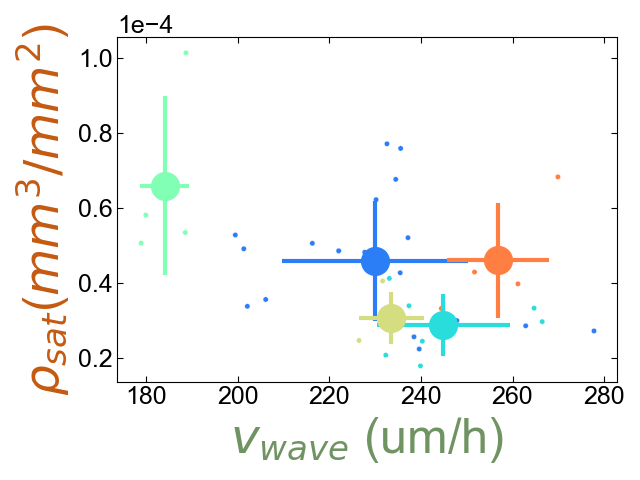

In [12]:
fig,ax = plt.subplots()
(x_col, y_col, label,xlabel,ylabel) =('speed', 'density_BV', '', '$v_{wave}$ (um/h)', r'$\rho_{sat}$($mm^3/mm^2$)')
df_select = df[df['real_root']=="Carrot Toby"]
plot_scatter_with_mean_and_ci(df_select, x_col, y_col, ax=ax, label=label)
ax.ticklabel_format(axis='y', style='sci',scilimits=(0,0))

ax.set_xlabel(xlabel,color = "#709461",fontsize = 35)
ax.set_ylabel(ylabel,color = "#C55A11",fontsize = 35)
ax.legend().remove()
plt.tight_layout()

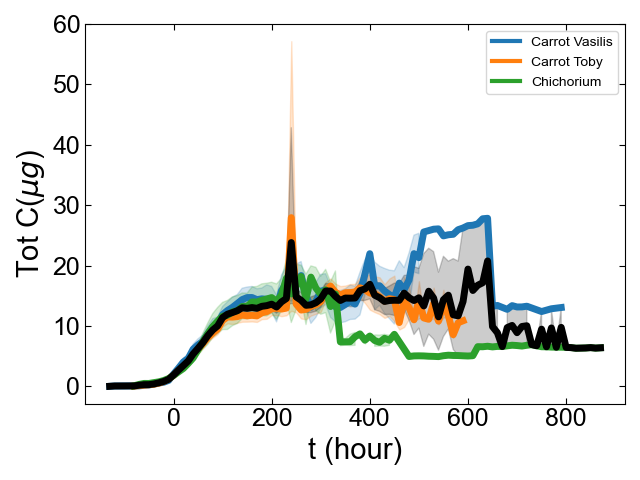

In [13]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_hypha'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_hypha'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,0.4)
ax.set_ylabel('Tot C($\mu g$)')
ax.set_xlabel('t (hour)')
# ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


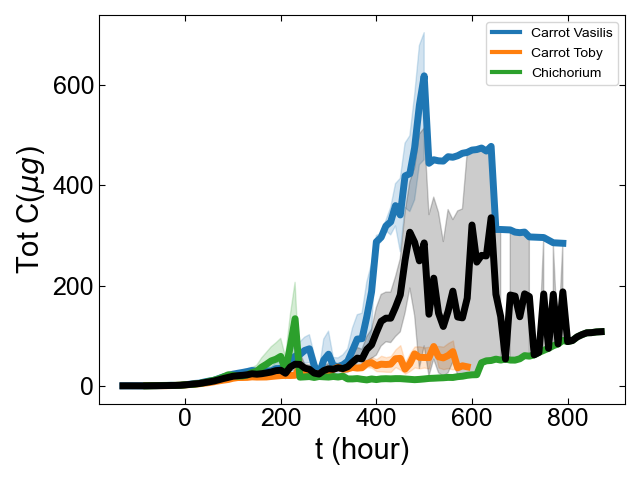

In [14]:
fig,ax = plt.subplots()
n_colors = len(final_data['strain'].unique())

tmax = 150
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = final_data[final_data['strain']=="C2"]

# sns.lineplot(data=select, x='time_since_begin_h_shifted', y=select['tot_biovolume_study'], hue='strain', style='strain_unique_id',ax=ax, palette=strain_to_color,lw = 1)
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_tot'], hue='real_root', ax=ax, estimator='mean', lw=5, ls="-")
sns.lineplot(data=select, x='time_hour_binned', y=select['totC_tot'], ax=ax, color = 'black', estimator='mean', lw=5, ls="-")

# ax.legend().remove()
ax.set_xlabel('t (hour)')
ax.set_ylabel('BV ($\mu m^3$)')
# ax.set_ylim(0,0.4)
ax.set_ylabel('Tot C($\mu g$)')
ax.set_xlabel('t (hour)')
# ax.set_xlim(-40, 75)
plt.tight_layout()
# plt.savefig(os.path.join('figures', 'time_biovolume.pdf'), transparent=True, bbox_inches='tight')


In [15]:

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = select[select['late_start']==False]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['totC_ma'] = select.groupby('strain')['totC'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='totC', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='totC_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
# ax.set_ylim(0,2e6)


KeyError: 'Column not found: totC'

In [ ]:

# Assuming select DataFrame and strain_to_color dictionary already exist
select = final_data[final_data['time_since_begin_h_shifted']<=tmax]
select = select[select['late_start']==False]

# Sort the data by strain and tot_surface_area_study
select = select.sort_values(by=['strain', 'time_since_begin_h_shifted'])

# Calculate moving average for each strain based on tot_surface_area_study ordering
window_size = 30
select['C_rate_ma'] = select.groupby('strain')['C_rate'].transform(lambda x: x.rolling(window=window_size,min_periods = 1).mean())

# Plotting
fig, ax = plt.subplots(figsize=(5,8))
sns.scatterplot(data=select, x='time_since_begin_h_shifted', y='C_rate', hue='strain', ax=ax, palette=strain_to_color, alpha=0.1)
sns.lineplot(data=select, x='time_since_begin_h_shifted', y='C_rate_ma', hue='strain', ax=ax, palette=strain_to_color, legend=False)  # suppress legend for lineplot
ax.set_ylim(0,0.6)
ax.set_ylabel('C provision rate ($\mu g/h$)')
ax.set_xlabel('t (hour)')
ax.set_xlim(-20,130)
